# Hospital Readmission Risk Prediction

**Goal**: *Predict whether a patient will be readmitted within 30 days of discharge.*

**Dataset**: *100k+ hospital encounters (UCI Diabetes 130-US hospitals dataset)*

In [1]:
# Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Load and Inspect Data

In [2]:
DATA_CSV = "diabetic_data.csv"    # main dataset
IDS_MAP_CSV = "IDS_mapping.csv"   # mapping for admission_type_id (adjust if different)
CLEANED_OUT = "cleaned_readmission_data.csv"
ENCODINGS_OUT = "categorical_encodings.json"

In [3]:
# Load data
data = pd.read_csv("data/" + DATA_CSV)
ids_map =  pd.read_csv("data/" + IDS_MAP_CSV)
df = data.copy()
print(f"Dataset Shape: {df.shape}")
display(df.head())

Dataset Shape: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
# Data Info summary
print("Dataset Info:", df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

### Data Cleaning & Preparation

In [5]:
# Replace '?' placeholders with NaN
df = df.replace('?', np.nan)

In [6]:
(df.isna().sum()/len(df)*100).sort_values(ascending=False).round(1).head(12)

weight               96.9
max_glu_serum        94.7
A1Cresult            83.3
medical_specialty    49.1
payer_code           39.6
race                  2.2
diag_3                1.4
diag_2                0.4
diag_1                0.0
encounter_id          0.0
troglitazone          0.0
tolbutamide           0.0
dtype: float64

#### Handling Missing Values

In [7]:
# ---------- Basic hygiene ----------
# Drop identifiers and columns we decided are too sparse
df = df.drop(columns=['encounter_id'], errors='ignore')

# Drop weight and max_glu_serum (very high missingness)
df = df.drop(columns=['weight', 'max_glu_serum', 'payer_code'], errors='ignore')

# A1Cresult: keep, fill missing as 'None' to preserve indicator that no test was done
df['A1Cresult'] = df['A1Cresult'].fillna('None')

# Fill some other common missing-values with 'Unknown'
df['medical_specialty'] = df['medical_specialty'].fillna('Unknown')
# df['payer_code'] = df['payer_code'].fillna('Unknown')
df['race'] = df['race'].fillna('Unknown')
df[['diag_1', 'diag_2', 'diag_3']] = df[['diag_1', 'diag_2', 'diag_3']].fillna('Unknown')

#### Merge DataFrames - IDS Mappings

In [8]:
# Read raw lines
with open("data/IDS_mapping.csv", "r") as f:
    lines = [line.strip() for line in f.readlines()]

# Split into blocks on completely blank lines or comma-only lines
blocks = []
current = []

for line in lines:
    if line == "" or line == ",":
        if current:
            blocks.append(current)
            current = []
    else:
        current.append(line)

# Add the last block if not empty
if current:
    blocks.append(current)


def parse_block(block):
    """
    Turn a block like:
    admission_type_id,description
    1,Emergency
    2,Urgent
    ...
    into a proper DataFrame.
    """
    header = block[0].split(",")[0]   # e.g. 'admission_type_id'
    df = pd.DataFrame([row.split(",", 1) for row in block[1:]], 
                      columns=["id", "value"])

    # Clean ID column
    df["id"] = df["id"].replace(["", " ", "NULL"], np.nan)
    df["id"] = pd.to_numeric(df["id"], errors="coerce").astype("Int64")  # nullable int

    # Clean value column
    df["value"] = df["value"].str.strip().replace("NULL", np.nan)

    # Rename for merge
    df = df.rename(columns={"value": header.replace("_id", "")})

    return header, df


# Parse each block
admission_type_id_col, admission_type_map = parse_block(blocks[0])
discharge_disposition_id_col, discharge_disposition_map = parse_block(blocks[1])
admission_source_id_col, admission_source_map = parse_block(blocks[2])

# Merge into main df 
df = df.merge(admission_type_map, left_on="admission_type_id", right_on="id", how="left")
df = df.merge(discharge_disposition_map, left_on="discharge_disposition_id", right_on="id", how="left")
df = df.merge(admission_source_map, left_on="admission_source_id", right_on="id", how="left")

# Drop duplicated 'id' merge columns
df = df.drop(columns=["id_x", "id_y"], errors="ignore")

In [9]:
# sanity check
print(f"Missing values: {df.isna().sum().sum()}")

Missing values: 15763


In [10]:
for col in ["admission_type", "discharge_disposition", "admission_source"]:
    df[col] = df[col].fillna("Unknown")

In [11]:
# Sanity check
print(f"Sum of Missing Values: {df.isnull().sum().sum()}")

Sum of Missing Values: 0


#### Age Transformation

In [12]:
# ---------- Age: convert bracket -> numeric midpoint ----------
def age_to_mid(a):
    try:
        a = str(a).strip()
        a = a.strip('[]').strip('()')
        lo, hi = a.split('-')
        return (int(lo) + int(hi)) / 2
    except:
        return np.nan

df['age_num'] = df['age'].apply(age_to_mid)
# keep original age bracket too if desired
df = df.drop(columns=['age'])

#### Target Encode

In [13]:
# ---------- Target: binary for <30 days ----------
df['readmit_30'] = df['readmitted'].apply(lambda x: 1 if str(x).strip() == '<30' else 0)
# keep original readmitted if you want; otherwise drop:
df = df.drop(columns=['readmitted'])

## Exploratory Data Analysis (EDA)

### Target Variable Distribution

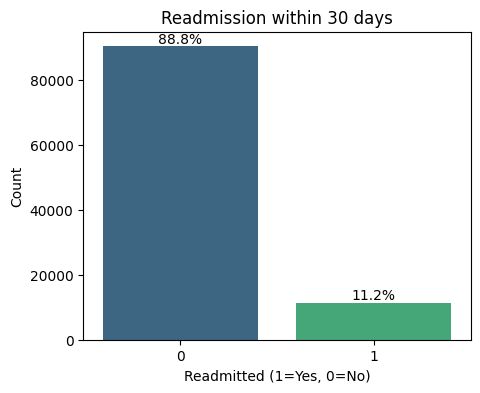

Readmission rate within 30 days: 11.16%


In [14]:
plt.figure(figsize=(5, 4))
ax = sns.countplot(x='readmit_30', data=df, palette='viridis')
plt.title("Readmission within 30 days")
plt.xlabel("Readmitted (1=Yes, 0=No)")
plt.ylabel("Count")

# Calculate total for percentages
total = len(df)

# Add percentage labels to bars
for p in ax.patches:
    height = p.get_height()
    percentage = 100 * height / total
    ax.text(p.get_x() + p.get_width() / 2., height + 3,
            f'{percentage:.1f}%', ha="center", va="bottom")

plt.show()

# Numeric summary
readmit_rate = df['readmit_30'].mean()*100
print(f"Readmission rate within 30 days: {readmit_rate:.2f}%")

### Demographics and Readmission Patterns

#### Age Groups

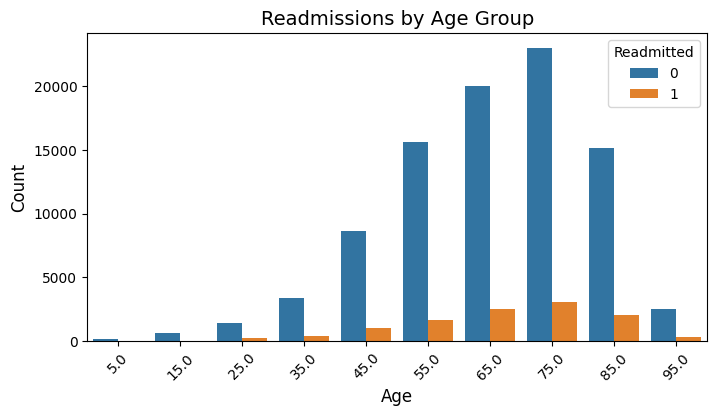

In [15]:
plt.figure(figsize=(8,4))
sns.countplot(x='age_num', hue='readmit_30', data=df)
plt.title('Readmissions by Age Group', fontsize=14)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Readmitted')
plt.show()

*Readmission risk apears to increase with age up to age group 70-80 then starts to drop. Age group 70-80 has the highest readmission rate.*

#### Race

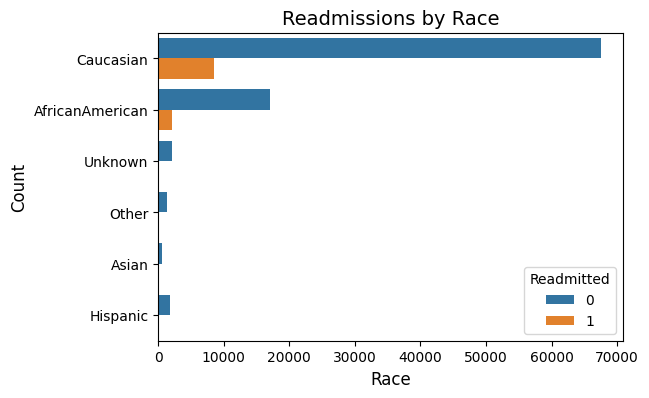

In [16]:
plt.figure(figsize=(6,4))
sns.countplot(y='race', hue='readmit_30', data=df)
plt.title('Readmissions by Race', fontsize=14)
plt.xlabel("Race", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title='Readmitted')
plt.show()

*Caucasian has the highest admission and readmission rate followed by AfricanAmerican*

#### Gender

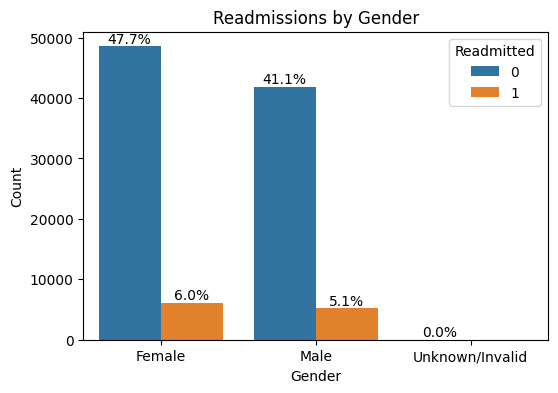

In [17]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='gender', hue='readmit_30', data=df)
plt.title('Readmissions by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Readmitted')

# Compute total counts per gender
totals = df['gender'].value_counts()

# Add percentage labels for each bar
for p in ax.patches:
    height = p.get_height()
    if height == 0:
        continue  # skip empty bars

    # Find which gender this bar belongs to
    x_category = p.get_x() + p.get_width() / 2
    x_index = int(round(x_category))
    gender = ax.get_xticklabels()[x_index].get_text()

    percentage = 100 * height / len(df)
    ax.text(p.get_x() + p.get_width() / 2., height + 3,
            f'{percentage:.1f}%', ha="center", va="bottom")

plt.show()

#### Medical Specialty Insights

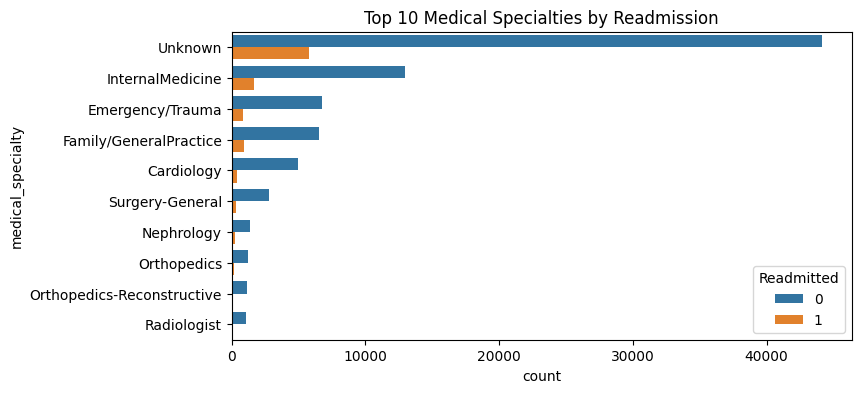

In [18]:
top_specialties = (
    df['medical_specialty']
    .value_counts()
    .head(10)
    .index
)
plt.figure(figsize=(8,4))
sns.countplot(y='medical_specialty', hue='readmit_30',
              data=df[df['medical_specialty'].isin(top_specialties)],
              order=top_specialties)
plt.title('Top 10 Medical Specialties by Readmission')
plt.legend(title='Readmitted')
plt.show()

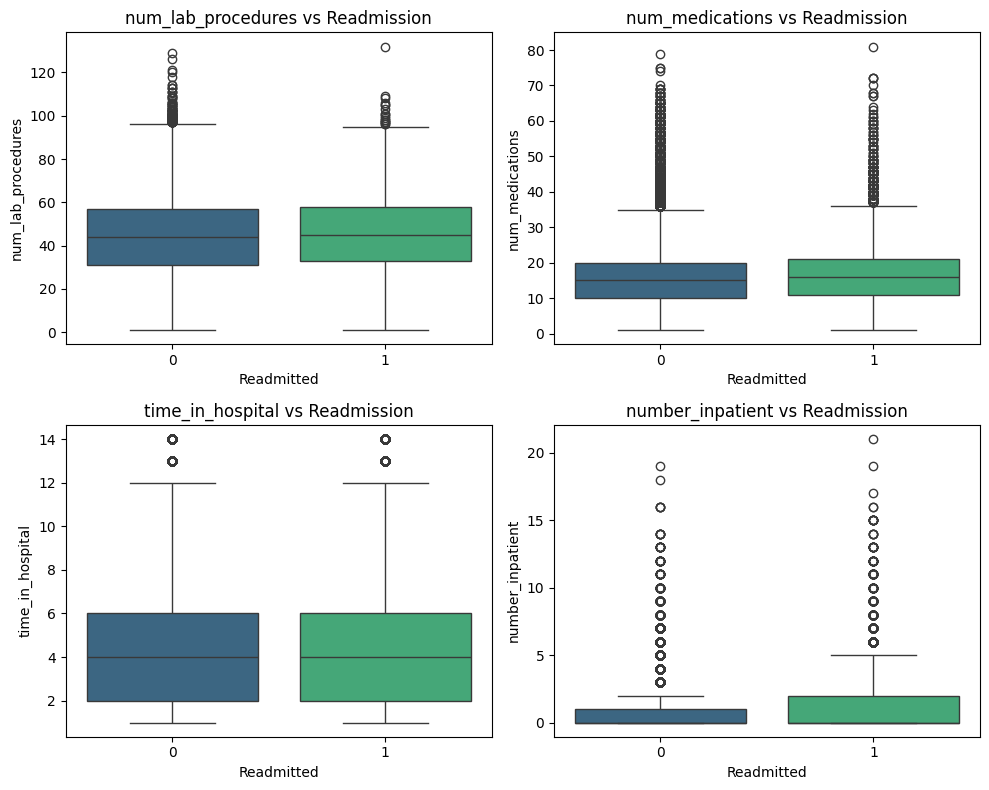

In [19]:
numeric_features = ['num_lab_procedures', 'num_medications', 'time_in_hospital', 'number_inpatient']
# Plot numeric features in a grid (2x2)
n_feats = len(numeric_features)
n_cols = 2
n_rows = int(np.ceil(n_feats / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes_flat = axes.flatten() if n_feats > 1 else [axes]

for i, col in enumerate(numeric_features):
    ax_i = axes_flat[i]
    sns.boxplot(x='readmit_30', y=col, data=df, ax=ax_i, palette='viridis')
    ax_i.set_title(f'{col} vs Readmission')
    ax_i.set_xlabel('Readmitted')
    ax_i.set_ylabel(col)

# Turn off any unused subplots
for j in range(i + 1, len(axes_flat)):
    axes_flat[j].axis('off')

plt.tight_layout()
plt.show()

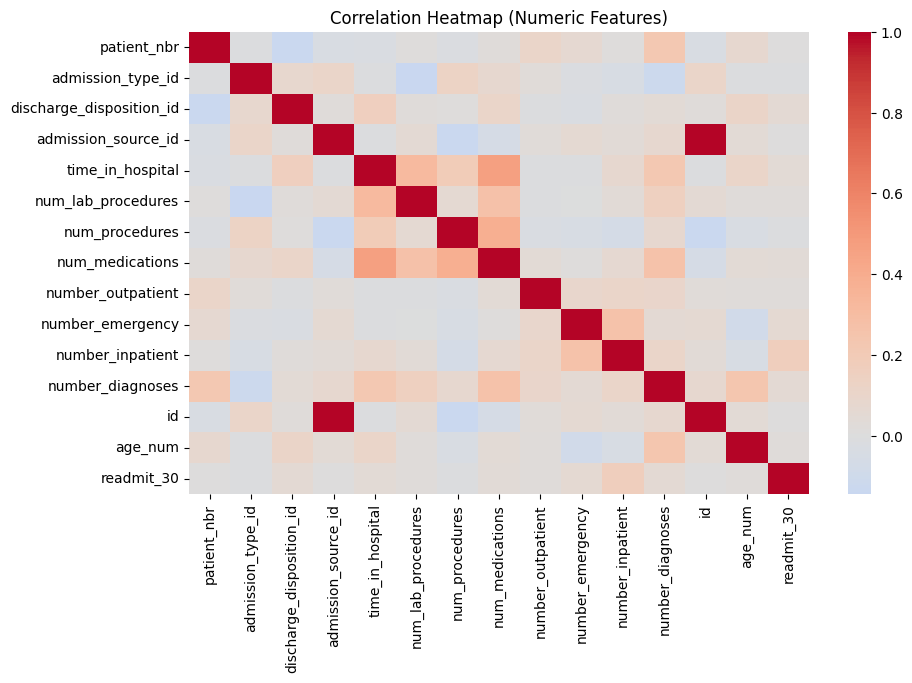

In [20]:
num_cols = df.select_dtypes(include=np.number).columns
corr = df[num_cols].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title('Correlation Heatmap (Numeric Features)')
plt.show()

## Feature Engineering

### Diagnosis Grouping

In [21]:
# Expanded ICD-9 grouping function (covers more clinical groups)

def diag_group_expanded(code):
    """
    Groups ICD-9 diagnosis codes into broad, clinically meaningful categories.
    More detailed than the basic version, but still compact.
    """
    try:
        c = float(code)
        # --- Infectious & Parasitic (001–139)
        if 1 <= c <= 139:
            return 'infectious'
        # --- Neoplasms (140–239)
        if 140 <= c <= 239:
            return 'neoplasms'
        # --- Endocrine, metabolic, immunity (240–279, except diabetes handled separately)
        if (240 <= c < 250) or (251 <= c <= 279):
            return 'endocrine_other'
        # --- Diabetes (250.xx)
        if 250 <= c < 251:
            return 'diabetes'
        # --- Blood diseases (280–289)
        if 280 <= c <= 289:
            return 'blood'
        # --- Mental disorders (290–319)
        if 290 <= c <= 319:
            return 'mental'
        # --- Nervous system (320–389)
        if 320 <= c <= 389:
            return 'neurological'
        # --- Circulatory system (390–459 + 785)
        if (390 <= c <= 459) or c == 785:
            return 'circulatory'
        # --- Respiratory (460–519 + 786)
        if (460 <= c <= 519) or c == 786:
            return 'respiratory'
        # --- Digestive (520–579 + 787)
        if (520 <= c <= 579) or c == 787:
            return 'digestive'
        # --- Genitourinary (580–629 + 788)
        if (580 <= c <= 629) or c == 788:
            return 'genitourinary'
        # --- Pregnancy / childbirth (630–679)
        if 630 <= c <= 679:
            return 'pregnancy'
        # --- Skin (680–709)
        if 680 <= c <= 709:
            return 'skin'
        # --- Musculoskeletal (710–739)
        if 710 <= c <= 739:
            return 'musculoskeletal'
        # --- Congenital anomalies (740–759)
        if 740 <= c <= 759:
            return 'congenital'
        # --- Perinatal conditions (760–779)
        if 760 <= c <= 779:
            return 'perinatal'
        # --- Symptoms / ICD V-codes (780–799)
        if 780 <= c <= 799:
            return 'symptoms'
        # --- Injury & poisoning (800–999)
        if 800 <= c <= 999:
            return 'injury'
        return 'other'

    except:
        return 'unknown'
    
# Apply to all diagnosis columns and create new grouped features

for col in ['diag_1', 'diag_2', 'diag_3']:
    if col in df.columns:
        df[col + '_group'] = df[col].apply(diag_group_expanded)
# Optional: drop raw ICD code columns
df = df.drop(columns=['diag_1', 'diag_2', 'diag_3'])

In [22]:
# ---------- Medication encoding (No/Steady/Up/Down -> ints) ----------
med_start = 'metformin'  # first med column name in dataset
# identify med columns dynamically from known column names list
med_cols = [
    'metformin','repaglinide','nateglinide','chlorpropamide','glimepiride',
    'acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone',
    'rosiglitazone','acarbose','miglitol','troglitazone','tolazamide',
    'examide','citoglipton','insulin','glyburide-metformin',
    'glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone',
    'metformin-pioglitazone'
]
med_cols = [c for c in med_cols if c in df.columns]

def med_to_int(val):
    if pd.isna(val):
        return 0
    v = str(val).strip().lower()
    if v in ['no', 'none']:
        return 0
    if v in ['steady', 'steady.']:
        return 1
    if v in ['up', 'up.']:
        return 2
    if v in ['down', 'down.']:
        return -1
    # fallback
    return 0

for c in med_cols:
    df[c+'_code'] = df[c].apply(med_to_int)
# optional: drop original med columns
df = df.drop(columns=med_cols)

In [23]:
# Synthetic medication feature engineering

# Identify all medication code columns (after encoding)
med_code_cols = [c for c in df.columns if c.endswith('_code')]

# Count how many meds changed (Up or Down).
#    Code 2 = Up, 3 = Down, -1 = missing → we treat Up/Down as "changed".
def count_changes(row):
    return ((row == 2) | (row == 3)).sum()

df['num_meds_changed'] = df[med_code_cols].apply(count_changes, axis=1)

# Binary flag: did ANY medication change?
df['any_med_change'] = (df['num_meds_changed'] > 0).astype(int)


# -------------------------
# 'change' column → flag
# -------------------------
# Original values include: "Ch", "No", "Ch", "No", "Ch", "No"
# But dataset sometimes contains messy strings like "No", "NO", "no"

if 'change' in df.columns:
    df['change_flag'] = df['change'].astype(str).str.lower().map(
        lambda x: 0 if x in ['no', 'no change', 'none'] else 1
    ).astype(int)

    df = df.drop(columns=['change'])


# -----------------------------
# diabetesMed → binary flag
# -----------------------------
if 'diabetesMed' in df.columns:
    df['diabetesMed_flag'] = (
        df['diabetesMed'].astype(str).str.lower().map({'yes': 1, 'no': 0}).fillna(0)
    ).astype(int)

    df = df.drop(columns=['diabetesMed'])

In [24]:
# ---------- Useful aggregated features ----------
df['prev_visits'] = df[['number_outpatient','number_emergency','number_inpatient']].sum(axis=1)
df['polypharmacy'] = (df['num_medications'] > 10).astype(int)
df['multi_diag'] = (df['number_diagnoses'] > 8).astype(int)
df['on_insulin'] = (df[[c for c in df.columns if c.endswith('insulin_code') or c.startswith('insulin')]].sum(axis=1) > 0).astype(int) \
    if any(c for c in df.columns if 'insulin' in c) else 0

In [25]:
# ---------- Categorical treatment: keep readable strings, then factorize ----------
# select categorical columns to factorize (we keep label versions for interpretability)
cat_cols = [
    'race','gender','medical_specialty','admission_type_label',
    'discharge_disposition_id','admission_source_id','payer_code',
    'A1Cresult','diag_1_group','diag_2_group','diag_3_group'
]
cat_cols = [c for c in cat_cols if c in df.columns]

categorical_mappings = {}
for c in cat_cols:
    # fill na just in case
    df[c] = df[c].fillna('Unknown').astype(str)
    codes, uniques = pd.factorize(df[c], sort=True)
    df[c + '_enc'] = codes
    # store mapping list for later reverse-lookup
    categorical_mappings[c] = list(uniques)

In [26]:
# ---------- 8. Final column selection ----------
# choose features to keep for modeling (example)
keep_cols = [
    'age_num','time_in_hospital','num_lab_procedures','num_procedures','num_medications',
    'number_outpatient','number_emergency','number_inpatient','number_diagnoses',
    'num_meds_changed','any_med_change','prev_visits','polypharmacy','multi_diag',
    'diabetesMed_flag','on_insulin'
]
# include encoded categorical columns
keep_cols += [c + '_enc' for c in cat_cols if (c + '_enc') in df.columns]
# include med_code columns
keep_cols += med_code_cols

In [27]:
# drop original categorical raw columns if you prefer final dataset compactness
# (we keep label columns + encoded columns; drop raw if not needed)
# df = df.drop(columns=[c for c in cat_cols])  


## Modeling

In [28]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report
import shap
from sklearn.model_selection import GroupShuffleSplit

In [29]:
# remove any duplicates and ensure cols exist
keep_cols = [c for c in keep_cols if c in df.columns]
X = df[keep_cols].copy()
y = df['readmit_30'].copy()

In [30]:
groups = df['patient_nbr']
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

Train size: 81613, Test size: 20153


In [31]:
# 12. Save cleaned dataset
# -------------------------
df_to_save = pd.concat([X, y], axis=1)
df_to_save.to_csv("/data/cleaned_diabetes_data.csv", index=False)

In [32]:
# import json
# import os

# # save categorical mappings for later inverse-transform / interpretation
# with open(ENCODINGS_OUT, 'w') as f:
#     json.dump(categorical_mappings, f, indent=2)

# print("Preprocessing complete.")
# print("Cleaned dataset saved to:", CLEANED_OUT)
# print("Categorical encodings saved to:", ENCODINGS_OUT)
# print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)

In [33]:
# !pip install shap

In [34]:
# Handle imbalance automatically using 'balanced' weights
train_weights = y_train.map({0: 1, 1: (len(y_train) - y_train.sum()) / y_train.sum()})

# LightGBM dataset objects
lgb_train = lgb.Dataset(X_train, label=y_train, weight=train_weights)
lgb_val = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

# Model parameters
params = {
    'objective': 'binary',
    'metric': ['auc', 'binary_logloss'],
    'boosting_type': 'gbdt',
    'learning_rate': 0.03,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42,
    'verbose': -1
}

In [35]:
from lightgbm import early_stopping

# Train model
model = lgb.train(
    params,
    lgb_train,
    num_boost_round=500,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(50)
    ]
)

# Predictions
y_pred_prob = model.predict(X_test, num_iteration=model.best_iteration)
y_pred = (y_pred_prob >= 0.5).astype(int)

Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.694248	train's binary_logloss: 0.641005	valid's auc: 0.667854	valid's binary_logloss: 0.642387
[100]	train's auc: 0.707916	train's binary_logloss: 0.627113	valid's auc: 0.670013	valid's binary_logloss: 0.631953
[150]	train's auc: 0.721752	train's binary_logloss: 0.617872	valid's auc: 0.671035	valid's binary_logloss: 0.627215
[200]	train's auc: 0.734209	train's binary_logloss: 0.61006	valid's auc: 0.671982	valid's binary_logloss: 0.622516
[250]	train's auc: 0.74469	train's binary_logloss: 0.603146	valid's auc: 0.672625	valid's binary_logloss: 0.618155
Early stopping, best iteration is:
[235]	train's auc: 0.741557	train's binary_logloss: 0.605193	valid's auc: 0.672808	valid's binary_logloss: 0.618898


ROC-AUC: 0.6728
PR-AUC:  0.2052

Confusion Matrix:
[[11885  6117]
 [  889  1262]]

Classification Report:
               precision    recall  f1-score   support

           0      0.930     0.660     0.772     18002
           1      0.171     0.587     0.265      2151

    accuracy                          0.652     20153
   macro avg      0.551     0.623     0.519     20153
weighted avg      0.849     0.652     0.718     20153



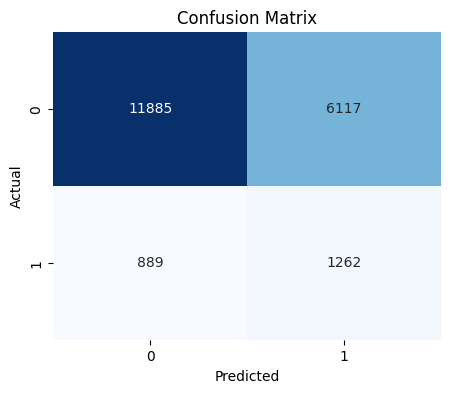

In [36]:
# ---------- Evaluation ----------
roc_auc = roc_auc_score(y_test, y_pred_prob)
pr_auc = average_precision_score(y_test, y_pred_prob)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=3)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC:  {pr_auc:.4f}")
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:\n", report)

# ---------- Confusion Matrix Plot ----------
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

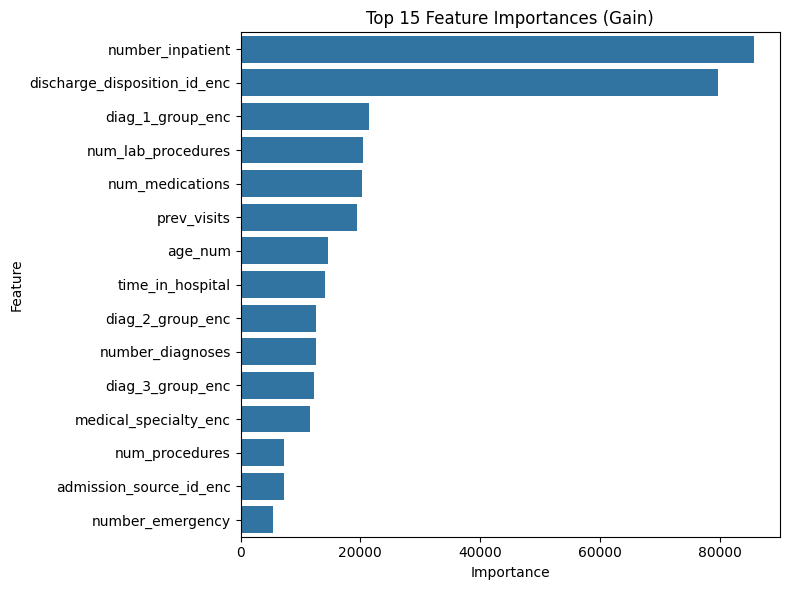

In [37]:
# ---------- Feature Importance ----------
importances = model.feature_importance(importance_type='gain')
feature_names = model.feature_name()
fi = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)
fi_df = pd.DataFrame(fi, columns=['Feature','Importance'])

plt.figure(figsize=(8,6))
sns.barplot(data=fi_df.head(15), x='Importance', y='Feature')
plt.title("Top 15 Feature Importances (Gain)")
plt.tight_layout()
plt.show()

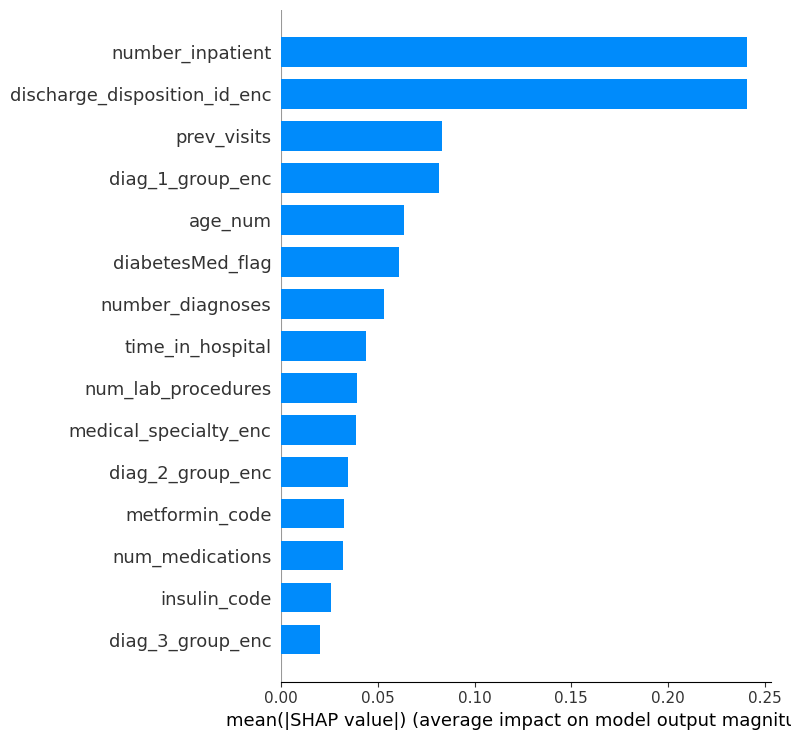

In [38]:
# ---------- SHAP Explainability ----------
%matplotlib inline

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Global feature importance (summary plot)
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=15)
plt.close() # clear figure

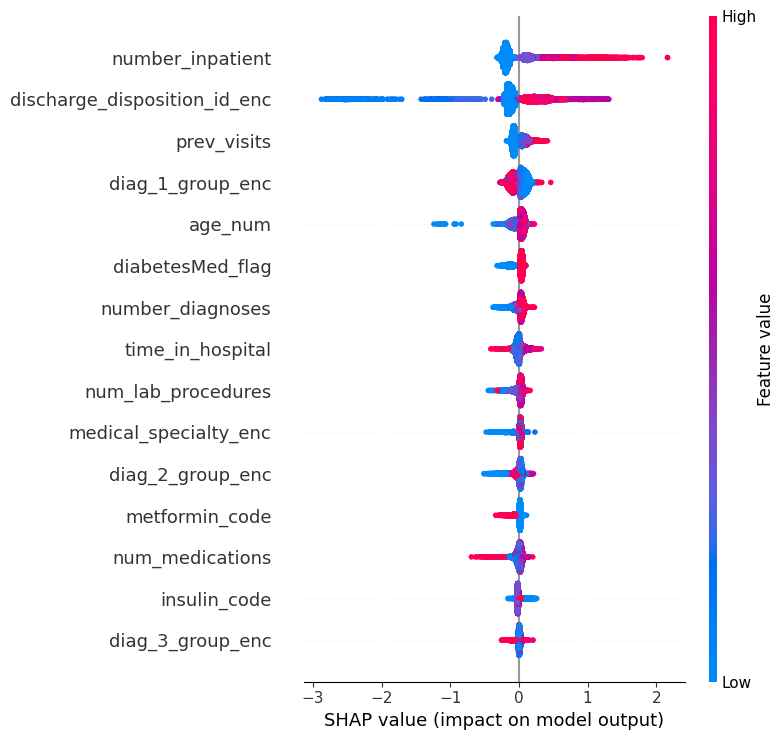

In [39]:
# full beeswarm summary for distribution of impacts
shap.summary_plot(shap_values, X_test, max_display=15)
plt.close() 